<a href="https://colab.research.google.com/github/rainmaker29/COVID19-Death-rate/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [0]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Download data
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv

--2020-05-03 13:35:25--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69256 (68K) [text/plain]
Saving to: ‘time_series_covid19_deaths_global.csv’

time_series_covid19 100%[===================>]  67.63K  --.-KB/s    in 0.01s   

2020-05-03 13:35:25 (4.58 MB/s) - ‘time_series_covid19_deaths_global.csv’ saved [69256/69256]



# PreProcessing

In [0]:
df = pd.read_csv('/content/drive/My Drive/covid/covid19_deaths.csv')

In [0]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,1,1,2,4,4,4,4,4,4,4,6,6,7,7,11,14,14,15,15,18,18,21,23,25,30,30,30,33,36
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,2,2,2,2,2,4,5,5,6,8,10,10,11,15,15,16,17,20,20,21,22,22,23,23,23,23,23,24,25,26,26,26,26,26
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,3,4,4,4,7,9,11,15,17,17,19,21,25,26,29,31,35,44,58,86,105,130,152,173,193,205,235,256,275,293,313,326,336,348,364,367,375,384
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,6,8,12,14,15,16,17,18,21,22,23,25,26,26,29,29,31,33,33,35,35,36,37
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [0]:
# removing the first four variables and using only the dates
df = df.iloc[:,4:]
df

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,1,1,2,4,4,4,4,4,4,4,6,6,7,7,11,14,14,15,15,18,18,21,23,25,30,30,30,33,36
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,2,2,2,2,2,4,5,5,6,8,10,10,11,15,15,16,17,20,20,21,22,22,23,23,23,23,23,24,25,26,26,26,26,26
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,3,4,4,4,7,9,11,15,17,17,19,21,25,26,29,31,35,44,58,86,105,130,152,173,193,205,235,256,275,293,313,326,336,348,364,367,375,384
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,6,8,12,14,15,16,17,18,21,22,23,25,26,26,29,29,31,33,33,35,35,36,37
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
260,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
261,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
#Checking for null values
df.isnull().sum().sum()

0

In [0]:
# Extracting daily deaths count from cumulative daily deaths count
daily_deaths = df.sum(axis=0)
daily_deaths.index = pd.to_datetime(daily_deaths.index)
daily_deaths.head()

2020-01-22    17
2020-01-23    18
2020-01-24    26
2020-01-25    42
2020-01-26    56
dtype: int64

Text(0.5, 1.0, 'Cumulative deaths')

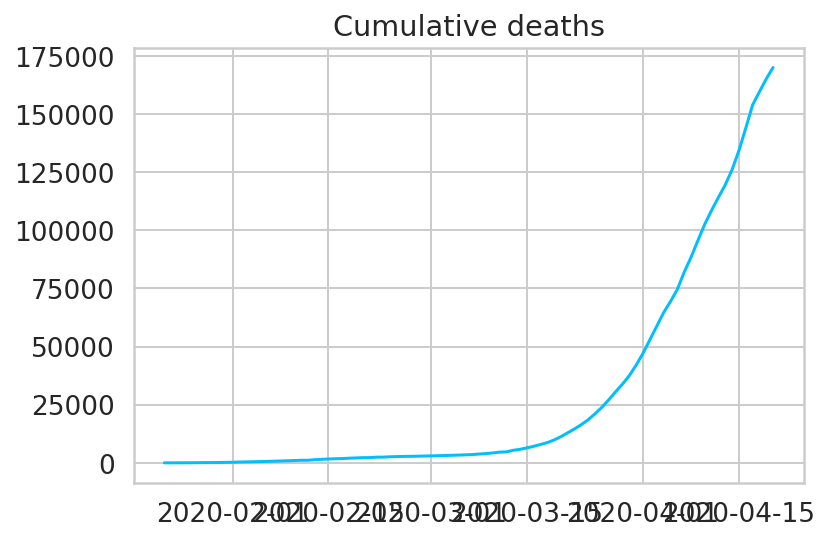

In [0]:
plt.plot(daily_deaths)

plt.title("Cumulative deaths")

In [0]:
daily_deaths = daily_deaths.diff().fillna(daily_deaths[0]).astype(np.int64)
daily_deaths.head()

2020-01-22    17
2020-01-23     1
2020-01-24     8
2020-01-25    16
2020-01-26    14
dtype: int64

Text(0.5, 1.0, 'Daily deaths')

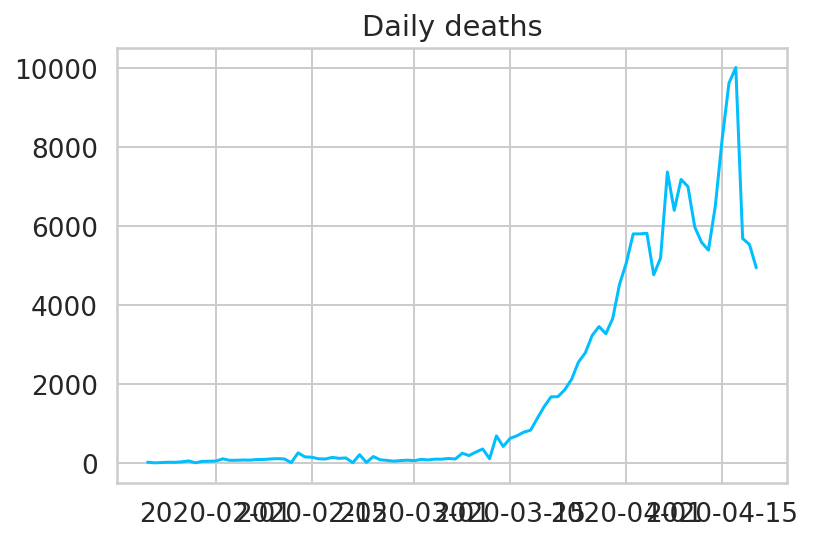

In [0]:
plt.plot(daily_deaths)
plt.title("Daily deaths")

In [0]:
daily_deaths.shape

(90,)

# Train-Test split and Scaling

In [0]:
test_data_size = 10
train_data = daily_deaths[:-test_data_size]
test_data = daily_deaths[-test_data_size:]
train_data.shape

(80,)

In [0]:
# We use scaling to speed up training process
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [0]:
# Creates sequences of fixed lengths
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [0]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [0]:
X_train.shape

torch.Size([74, 5, 1])

In [0]:
X_train[:2]

tensor([[[0.0022],
         [0.0000],
         [0.0009],
         [0.0020],
         [0.0018]],

        [[0.0000],
         [0.0009],
         [0.0020],
         [0.0018],
         [0.0034]]])

In [0]:
y_train.shape

torch.Size([74, 1])

In [0]:
y_train[:2]

tensor([[0.0034],
        [0.0065]])

In [0]:
train_data[:10]

array([[0.00217067],
       [0.        ],
       [0.00094967],
       [0.002035  ],
       [0.00176367],
       [0.00339167],
       [0.00651201],
       [0.00013567],
       [0.00501967],
       [0.00556234]])

# Model

In [0]:
class CoronaVirusPredictor(nn.Module):
  def __init__(self,n_features,n_hidden,seq_len,n_layers=2):
    super(CoronaVirusPredictor,self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers
    # A set of LSTM layers followed by a Dense/Linear layer that intakes the 
    # final time step from the final LSTM layer
    self.lstm = nn.LSTM(
        input_size=n_features,
        hidden_size=n_hidden,
        num_layers = n_layers,
        dropout=0.5

    )

    self.linear = nn.Linear(in_features=n_hidden,out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers,self.seq_len,self.n_hidden),
        torch.zeros(self.n_layers,self.seq_len,self.n_hidden)
    )

  def forward(self,sequences):
    lstm_out,self.hidden = self.lstm(
        sequences.view(len(sequences),self.seq_len,-1),
        self.hidden
    )

    last_time_step = lstm_out.view(self.seq_len,len(sequences),self.n_hidden)[-1]

    y_pred = self.linear(last_time_step)
    return y_pred


# Training

In [0]:
def train_model(model,epochs,train_data,train_labels,test_data=None,test_labels=None):
  
  loss_fn = torch.nn.MSELoss(reduction='sum')
  optimiser = torch.optim.Adam(model.parameters(),lr=1e-3)
  epochs=epochs

  train_hist = np.zeros(epochs)
  test_hist = np.zeros(epochs)

  for t in range(epochs):
    # reset hidden state since we're using stateless LSTMs
    model.reset_hidden_state()

    y_pred = model(train_data)

    loss = loss_fn(y_pred.float(),train_labels)


    if test_data is not None:
      #turn off gradient for test/validation prediction
      with torch.no_grad():
        
        y_test_pred = model(test_data)
        test_loss = loss_fn(y_test_pred.float(),test_labels)
      test_hist[t] = test_loss.item()

      if t%10==0:
        print(f'Epoch {t} train loss : {loss.item()} test loss : {test_loss.item()}')

    elif t%10==0:
      print(f'Epoch {t} train loss {loss.item()}')


    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

  return model.eval(),train_hist,test_hist


In [0]:
model = CoronaVirusPredictor(
    n_features = 1,
    n_hidden=120,
    seq_len=seq_length,
    n_layers=3
    )

model, train_hist, test_hist = train_model(
  model = model,
  epochs=120,
  train_data = X_train,
  train_labels = y_train,
  test_data  = X_test,
  test_labels = y_test
)

# Best hyperparameters observed as of now
    # n_features = 1,
    # n_hidden=120,
    # seq_len=seq_length,
    # n_layers=3

Epoch 0 train loss : 6.8852105140686035 test loss : 4.354400634765625
Epoch 10 train loss : 5.432178974151611 test loss : 3.386497974395752
Epoch 20 train loss : 4.120081901550293 test loss : 2.0075178146362305
Epoch 30 train loss : 2.431189775466919 test loss : 2.5409536361694336
Epoch 40 train loss : 1.3158632516860962 test loss : 1.4478495121002197
Epoch 50 train loss : 1.7354581356048584 test loss : 3.8745899200439453
Epoch 60 train loss : 1.2947664260864258 test loss : 1.2669076919555664
Epoch 70 train loss : 1.2321836948394775 test loss : 0.5428574085235596
Epoch 80 train loss : 1.0305477380752563 test loss : 0.434100866317749
Epoch 90 train loss : 0.8283181190490723 test loss : 0.6154117584228516
Epoch 100 train loss : 0.9718959927558899 test loss : 0.33286911249160767
Epoch 110 train loss : 0.9035385847091675 test loss : 0.4442078769207001


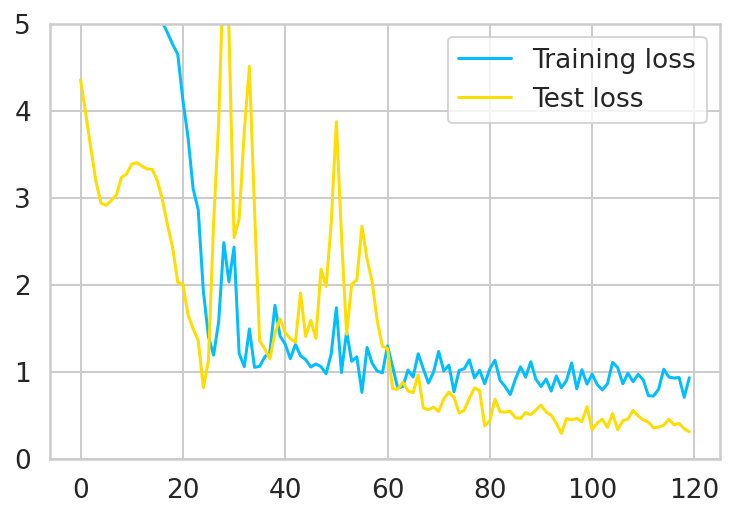

In [0]:
# Train vs Test loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

In [0]:
# Reusing the predicted values as input for next days
# as our model predicts only for the next single day

with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [0]:
true_deaths = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_deaths = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

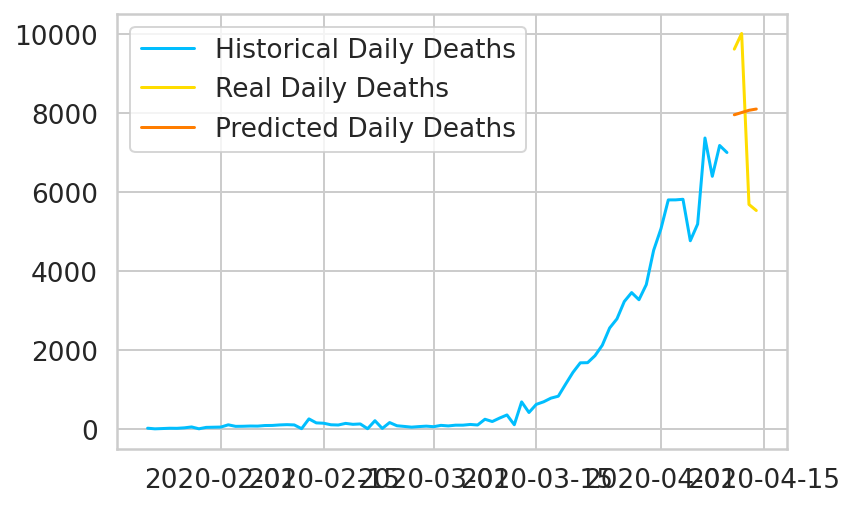

In [0]:
plt.plot(
  daily_deaths.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Deaths'
)

plt.plot(
  daily_deaths.index[len(train_data):len(train_data) + len(true_deaths)],
  true_deaths,
  label='Real Daily Deaths'
)

plt.plot(
  daily_deaths.index[len(train_data):len(train_data) + len(true_deaths)],
  predicted_deaths,
  label='Predicted Daily Deaths'
)

plt.legend();

In [0]:
# Repeating the same preprocessing but for entire data
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_deaths, axis=1))

all_data = scaler.transform(np.expand_dims(daily_deaths, axis=1))

all_data.shape

(90, 1)

In [0]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=120,
  seq_len=seq_length,
  n_layers=3
)
model, train_hist, _ = train_model(model=model,epochs=120,train_data=X_all, train_labels=y_all)

Epoch 0 train loss 10.735997200012207
Epoch 10 train loss 6.061316967010498
Epoch 20 train loss 6.005399703979492
Epoch 30 train loss 5.066762924194336
Epoch 40 train loss 2.592839241027832
Epoch 50 train loss 1.339086651802063
Epoch 60 train loss 1.131709098815918
Epoch 70 train loss 1.1012182235717773
Epoch 80 train loss 0.8985336422920227
Epoch 90 train loss 0.9701874256134033
Epoch 100 train loss 0.812328577041626
Epoch 110 train loss 0.9884158372879028


In [0]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [0]:
predicted_deaths = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [0]:
daily_deaths.index[-1]

Timestamp('2020-04-20 00:00:00')

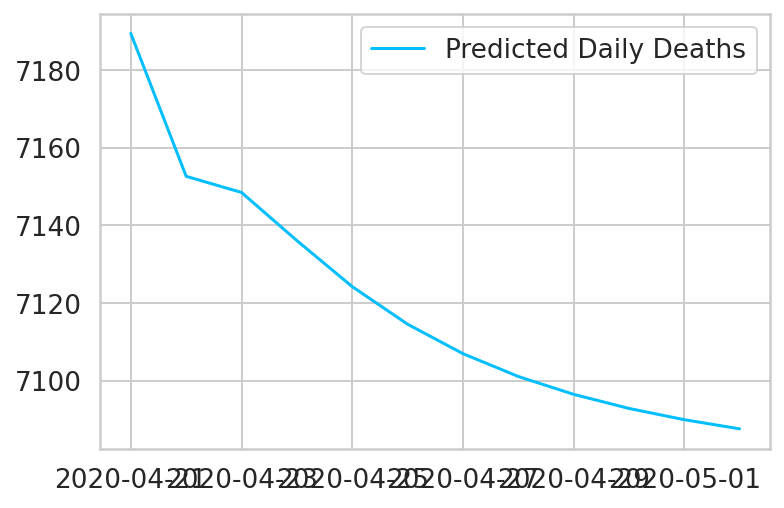

In [0]:
predicted_index = pd.date_range(
  start=daily_deaths.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_deaths = pd.Series(
  data=predicted_deaths,
  index=predicted_index
)

plt.plot(predicted_deaths, label='Predicted Daily Deaths')
plt.legend();

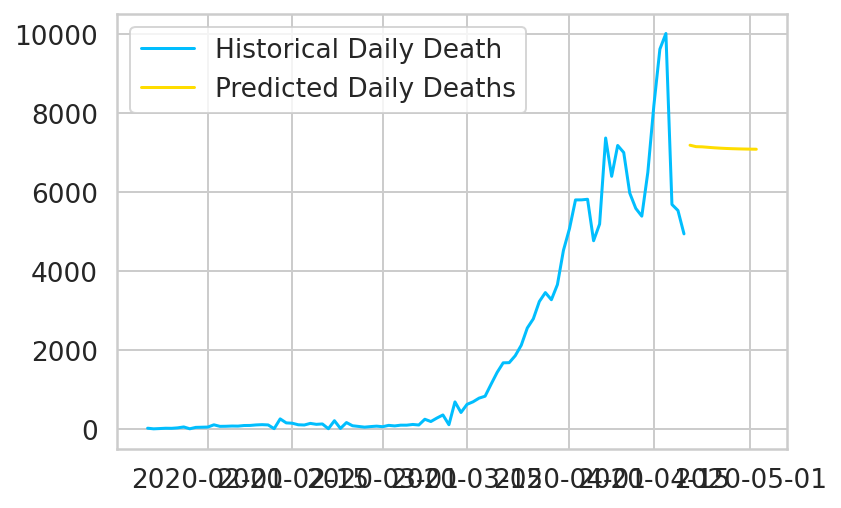

In [0]:
plt.plot(daily_deaths, label='Historical Daily Death')
plt.plot(predicted_deaths, label='Predicted Daily Deaths')
plt.legend();